# Neural Networks Coursework 

## Data Loading 

In [1]:
#Mounting google drive to easily access data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Imports and external Libraries 

In [2]:
#various imports

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import notebook
!pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=26ca2a033ec723de0e9a205bcac9cd205b375df19706c9cd73ef4f862eec7dae
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


Loading files

In [3]:
# Runs code on the best available Processor
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

# And let's initialize the model.
#model = C2FC3(num_classes).to(device)

True

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
#Includes input normalisation, colour jitter (colour operations), horizontalflips, 
#rotations and affine -- for training set -> includes validation
transform_train = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
     transforms.ColorJitter(brightness=0.2, contrast=0.3, saturation=0.3),  
     transforms.RandomHorizontalFlip(), # FLips images
     transforms.RandomRotation(10),     #Rotates the image to a specified angel
     transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)) #Zoom and angle changes
     ])
#transform for test_set - also normalized to have consistent images
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


#specified batch size
batch_size = 4

#Epoch size
num_epochs = 10

#trainset initialized here using pytorch function
train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

#train validation split with trainloader
#40.000 training images and 10.000 validation images remain

torch.manual_seed(43)
train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_data, val_data = torch.utils.data.random_split(train_set, [train_size, val_size])

print(len(train_data))
print(len(val_data))

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2, pin_memory=True)
print(len(trainloader))

valloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2, pin_memory=True)
print(len(valloader))

#same with test set
test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2, pin_memory=True)
#print(len(testloader))
#10 classes - 10 potential predicitions by model
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
40000
10000
10000
2500
Files already downloaded and verified


In [ ]:
train_set.data

Printing out example image

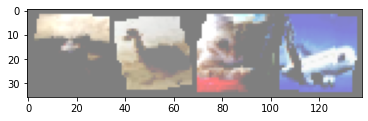

ship  bird  cat   airplane


In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

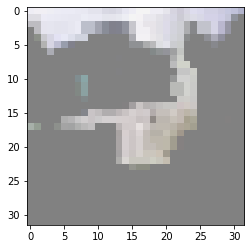

In [ ]:
#example image using imshow function
imshow(images[1])

In [ ]:
#understanding image shape
images[1].shape

torch.Size([3, 32, 32])

## Training and Models

### Model 1

#### old model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

#2 Hidden Layers - simple model --> with dropout --> later added batch normalisation
class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.batch1 = nn.BatchNorm2d(6, eps=1e-05, momentum=0.4, affine=True)
        self.drop = nn.Dropout(p=0.5, inplace=False)
        #self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.batch2 = nn.BatchNorm2d(16, eps=1e-05, momentum=0.4, affine=True)
        self.drop = nn.Dropout(p=0.5, inplace=False)
        #self.pool = nn.AvgPool2d(2, 2)
        #from convolutional to linear layer - required further calculations
        self.fc1 = nn.Linear(16 * 5 * 5, 10)
        #self.drop = nn.Dropout(p=0.5, inplace=False)
        

    def forward(self, x):
        #x = F.relu(self.conv1(x))
        #x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv1(x)))
        x = self.batch1(x)
        x = self.drop(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.batch2(x)
        x = self.drop(x)
        #x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions excluding batch
        x = F.relu(self.fc1(x))
        return x


model1 = Net1()

#### new model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

#3 Hidden Layers - fully linear layer - just utilises dropout - most accurate out of 3 4-layer models
class Net21(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32 * 3, 1024)
        #self.drop1 = nn.Dropout(p=0.5, inplace=False)
        self.fc2 = nn.Linear(1024, 512)
        #self.drop2 = nn.Dropout(p=0.5, inplace=False)
        self.fc3 = nn.Linear(512, 64)
        #self.drop3 = nn.Dropout(p=0.5, inplace=False)
        self.fc4 = nn.Linear(64, 16)
        #self.drop4 = nn.Dropout(p=0.8, inplace=False)
        self.fc5 = nn.Linear(16, 10)
        #self.drop5 = nn.Dropout(p=0.8, inplace=False)
        

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.softmax(self.fc1(x), dim =1)
        #x = self.drop1(x)
        x = F.softmax(self.fc2(x), dim =1)
        #x = self.drop2(x)
        x = F.softmax(self.fc3(x), dim =1)
        #x = self.drop3(x)
        x = F.softmax(self.fc4(x), dim=1)
        #x = self.drop4(x)
        x = F.softmax(self.fc5(x), dim=1)
        #x = self.drop5(x)
        return x


model21 = Net21()

In [ ]:
#3 Hidden Layers - features to convolutional layers and multiple batchnorm
#and dropout operations includes average pooling operations as well
import torch.nn as nn
import torch.nn.functional as F
class Net22(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=(5, 5))
        self.pool = nn.MaxPool2d(2, 2)
        #self.pool = nn.AvgPool2d(2,2)
        self.batch1 = nn.BatchNorm2d(6, eps=1e-05, momentum=0.4, affine=True)
        self.drop1 = nn.Dropout(p=0.5, inplace=False)
      
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(5, 5))
        self.pool = nn.MaxPool2d(2, 2)
        #self.pool = nn.AvgPool2d(2,2)
        self.batch2 = nn.BatchNorm2d(16, eps=1e-05, momentum=0.4, affine=True)
        self.drop2 = nn.Dropout(p=0.5, inplace=False)

        self.fc1 = nn.Linear(16 * 5 * 5, 256)  # 5*5 from image dimension
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128, 10)
        self.drop5 = nn.Dropout(p=0.5, inplace=False)   
        

    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.batch1(x)
        x = self.drop1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.batch2(x)
        x = self.drop2(x)
        #x = F.relu(self.conv3(x))
        #x = self.batch3(x)
        #x = self.drop3(x)
        #x = F.relu(self.conv4(x))
        #x = self.batch4(x)
        #x = self.drop4(x)
        #x = x.reshape(x.shape[0], -1)
        #x = x.view(-1, 5*5*128)
        x = torch.flatten(x, 1)
        x = F.softmax(self.fc1(x), dim=1)
        x = F.softmax(self.fc2(x), dim=1)
        x = F.softmax(self.fc3(x), dim=1)
        x = self.drop5(x)
        return x


model22 = Net22().to(device)

In [ ]:
model22.type

<bound method Module.type of Net22(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch1): BatchNorm2d(6, eps=1e-05, momentum=0.4, affine=True, track_running_stats=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.4, affine=True, track_running_stats=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (drop5): Dropout(p=0.5, inplace=False)
)>

In [ ]:
#model summary --> helps with understanding layer composition 
from torchvision import models
from torchsummary import summary
summary(model22,(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
       BatchNorm2d-3            [-1, 6, 14, 14]              12
           Dropout-4            [-1, 6, 14, 14]               0
            Conv2d-5           [-1, 16, 10, 10]           2,416
         MaxPool2d-6             [-1, 16, 5, 5]               0
       BatchNorm2d-7             [-1, 16, 5, 5]              32
           Dropout-8             [-1, 16, 5, 5]               0
            Linear-9                  [-1, 256]         102,656
           Linear-10                  [-1, 128]          32,896
           Linear-11                   [-1, 10]           1,290
          Dropout-12                   [-1, 10]               0
Total params: 139,758
Trainable params: 139,758
Non-trainable params: 0
-------------------------------

In [ ]:
#using torchviz library - print out the structure and exact dimensional 
#operations with network architecture
from torchviz import make_dot
x = torch.randn(6, 3, 32, 32)
y = model22(x)
make_dot(y.mean(), params=dict(model22.named_parameters()))

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ExponentialLR, ReduceLROnPlateau
criterion = nn.CrossEntropyLoss()
#first attempt with Schocastic Gradient Descent optimizer
optimizer1 = optim.SGD(model22.parameters(), lr=0.001, momentum=0.9, dampening=0, weight_decay=1e-4, nesterov=False)
#optimizer1 = optim.Adam(model22.parameters(),lr=0.05, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-8, amsgrad=False)
  #optimizer1 = optim.RMSprop(model1.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
scheduler = ExponentialLR(optimizer1, gamma=0.9)
#Using MultistepScheduler to define milestone for changes in learning rate
#scheduler = MultiStepLR(optimizer1, milestones=[0,1], gamma=0.1)

In [ ]:
total_epochs = notebook.tqdm(range(num_epochs))
train_graph_losses = []
train_acc = []
for epoch in range(num_epochs):  
    running_loss = 0.0
    correct = 0.0
    total = 0  
    for i, data in enumerate(trainloader):
        inputs,labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer1.zero_grad()

        outputs = model22(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer1.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)   
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        mean_train_accuracy = (100 * correct / total) 
        running_loss=running_loss/len(trainloader)

    train_graph_losses.append(running_loss)
    train_acc.append(mean_train_accuracy) 

    scheduler.step()  
    
print('Validation Accuracy: %d %%' % (mean_train_accuracy)) 
print('Validation Loss:'  ,running_loss)      
print('Finished Training')

train data =  50
traindata.dataset = 40% - 39%
total = 

#### Model 1 (Validation)

In [ ]:
#Validation data step - similar in structure to training data
#No gradient operations as specified by model.eval and torch.no_grad()
val_acc = []
val_graph_losses = []     
for epoch in total_epochs:  #looping through dataset 
  correct = 0                                               
  total = 0                                                 
  val_running_loss = 0.0   
  model22.eval()                                              
  with torch.no_grad():                                     
    for i,data in enumerate(valloader,0):
      inputs, labels = data  
      inputs, labels = inputs.to(device), labels.to(device)
       
                               
      outputs = model22(inputs)                           
      loss = criterion(outputs, labels)       
      val_running_loss += loss.item()          
      _, predicted = torch.max(outputs.data, 1)         
      total += labels.size(0)                        
      correct += (predicted == labels).sum().item()    

      #Storing loss and accuracy values  
        
    val_running_loss=running_loss/len(trainloader)          
    mean_val_accuracy = (100 * correct / total)   

    val_graph_losses.append(running_loss) 
    val_acc.append(mean_val_accuracy)      

    print('Train Loss: %.3f | Accuracy: %.3f'%(running_loss,mean_train_accuracy))      
           
  print('Validation Accuracy: %d %%' % (mean_val_accuracy))     

print('Accuracy of the network on the 10000 val images: {} %'.format(100 * correct / total))

Train Loss: 0.576 | Accuracy: 10.280
Validation Accuracy: 10 %
Train Loss: 0.576 | Accuracy: 10.280
Validation Accuracy: 10 %
Train Loss: 0.576 | Accuracy: 10.280
Validation Accuracy: 10 %
Train Loss: 0.576 | Accuracy: 10.280
Validation Accuracy: 10 %
Train Loss: 0.576 | Accuracy: 10.280
Validation Accuracy: 10 %
Train Loss: 0.576 | Accuracy: 10.280
Validation Accuracy: 10 %
Train Loss: 0.576 | Accuracy: 10.280
Validation Accuracy: 10 %
Train Loss: 0.576 | Accuracy: 10.280
Validation Accuracy: 10 %
Train Loss: 0.576 | Accuracy: 10.280
Validation Accuracy: 10 %
Train Loss: 0.576 | Accuracy: 10.280
Validation Accuracy: 10 %
Accuracy of the network on the 10000 val images: 10.28 %


No handles with labels found to put in legend.


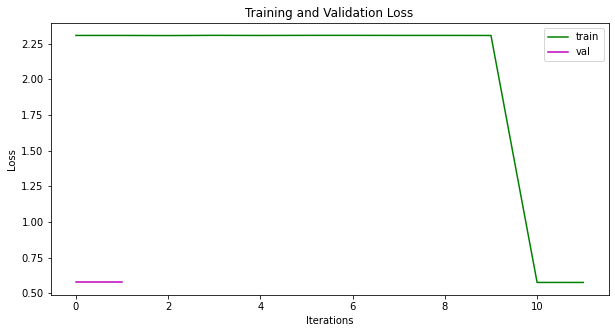

In [ ]:
#Ploting Loss
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(train_graph_losses, color ="g")
plt.plot(val_graph_losses, color = "m")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(['train', 'val'])
plt.show()

No handles with labels found to put in legend.


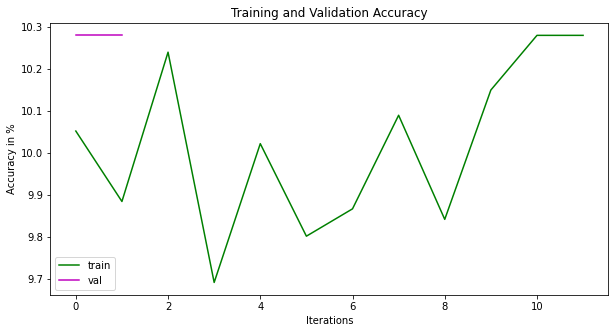

In [ ]:
#Plotting accuracy
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(train_acc, color ="g")
plt.plot(val_acc, color = "m")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Accuracy in %")
plt.legend(['train', 'val'])
plt.show()

### Model 2

In [13]:
#2 Hidden Layers Layers - fully linear layer - just utilises dropout - most accurate out of 3 4-layer models
import torch.nn as nn
import torch.nn.functional as F
class Net32(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32 * 3, 1024)
        self.drop = nn.Dropout(p=0.5, inplace=False)
        self.fc2 = nn.Linear(1024, 512)
        self.drop = nn.Dropout(p=0.5, inplace=False)
        self.fc3 = nn.Linear(512, 128)
        self.drop = nn.Dropout(p=0.5, inplace=False)
        self.fc4 = nn.Linear(128, 10)
        self.drop = nn.Dropout(p=0.5, inplace=False)
        

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = F.relu(self.fc3(x))
        x = self.drop(x)
        x = F.relu(self.fc4(x))
        x = self.drop(x)
        return x


model32 = Net32().to(device)

In [17]:
import torch.nn as nn
import torch.nn.functional as F

# 2 Hidden Layer model - fully convolutional - using dropout and batchnorm
class Net31(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=(3, 3), stride=1, padding=0)
        self.pool = nn.MaxPool2d(2, 2)
        self.batch1 = nn.BatchNorm2d(6, eps=1e-05, momentum=0.4, affine=True)
        self.drop = nn.Dropout(p=0.5, inplace=False)

        self.conv2 = nn.Conv2d(6, 16, kernel_size=(3, 3), stride=1, padding=0)
        self.pool = nn.MaxPool2d(2, 2)
        self.batch2 = nn.BatchNorm2d(16, eps=1e-05, momentum=0.4, affine=True)
        self.drop = nn.Dropout(p=0.5, inplace=False)

        self.conv3 = nn.Conv2d(16, 64, kernel_size=(3, 3), stride=1, padding=0)
        #self.pool = nn.MaxPool2d(2, 2)
        self.batch3 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.4, affine=True)
        self.drop = nn.Dropout(p=0.5, inplace=False)

        self.conv4 = nn.Conv2d(64, 10, kernel_size=(3, 3), stride=1, padding=0)
        #self.batch3 = nn.BatchNorm2d(10, eps=1e-05, momentum=0.4, affine=True)
        self.drop = nn.Dropout(p=0.5, inplace=False)
        #self.pool = nn.MaxPool2d(2, 2)
        #self.fc1 = nn.Linear(32 * 10 * 10, 10)
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.batch1(x)
        x = self.drop(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.batch2(x)
        x = self.drop(x)
        x = F.relu(self.conv3(x))
        x = self.drop(x)
        x = F.relu(self.conv4(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.drop(x)
        return x


model31 = Net31().to(device)

In [18]:
import torch.nn as nn
import torch.nn.functional as F

#2 Hidden Layers - 3 convolutional layers and 1 fully connected (linear) layer
class Net33(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=(3, 3), stride=1, padding=0)
        self.pool = nn.MaxPool2d(2, 2)
        self.batch1 = nn.BatchNorm2d(16, eps=1e-05, momentum=0.4, affine=True)
        self.drop = nn.Dropout(p=0.5, inplace=False)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=1, padding=0)
        self.pool = nn.MaxPool2d(2, 2)
        self.batch2 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.4, affine=True)
        self.drop = nn.Dropout(p=0.5, inplace=False)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=0)
        #self.pool = nn.MaxPool2d(2, 2)
        self.batch3 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.4, affine=True)
        self.drop = nn.Dropout(p=0.5, inplace=False)
       
        self.fc1 = nn.Linear(4*4*64, 10) # I/p image size is 32*32, after 3 MaxPooling layers it reduces to 4*4 and 64 because our last conv layer has 64 outputs. Output nodes is 500
        self.drop = nn.Dropout(p=0.5, inplace=False)
        
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.batch1(x)
        x = self.drop(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.batch2(x)
        x = self.drop(x)
        x = F.relu(self.conv3(x))
        x = self.batch3(x)
        x = self.drop(x)
        x = x.reshape(x.shape[0], -1)
        x = x.view(-1, 4*4*64)
        x = F.softmax(self.fc1(x), dim=1)
        x = self.drop(x)
        return x


model33 = Net33().to(device)

In [14]:
model32.type

<bound method Module.type of Net32(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)>

In [15]:
#model summary --> helps with understanding layer composition 
#to see different models change model name according to different model classes 
from torchvision import models
from torchsummary import summary
summary(model32,(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]       3,146,752
           Dropout-2                 [-1, 1024]               0
            Linear-3                  [-1, 512]         524,800
           Dropout-4                  [-1, 512]               0
            Linear-5                  [-1, 128]          65,664
           Dropout-6                  [-1, 128]               0
            Linear-7                   [-1, 10]           1,290
           Dropout-8                   [-1, 10]               0
Total params: 3,738,506
Trainable params: 3,738,506
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 14.26
Estimated Total Size (MB): 14.30
----------------------------------------------------------------


In [19]:
summary(model31,(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 30, 30]             168
         MaxPool2d-2            [-1, 6, 15, 15]               0
       BatchNorm2d-3            [-1, 6, 15, 15]              12
           Dropout-4            [-1, 6, 15, 15]               0
            Conv2d-5           [-1, 16, 13, 13]             880
         MaxPool2d-6             [-1, 16, 6, 6]               0
       BatchNorm2d-7             [-1, 16, 6, 6]              32
           Dropout-8             [-1, 16, 6, 6]               0
            Conv2d-9             [-1, 64, 4, 4]           9,280
          Dropout-10             [-1, 64, 4, 4]               0
           Conv2d-11             [-1, 10, 2, 2]           5,770
          Dropout-12                   [-1, 40]               0
Total params: 16,142
Trainable params: 16,142
Non-trainable params: 0
---------------------------------

In [20]:
summary(model33,(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             448
         MaxPool2d-2           [-1, 16, 15, 15]               0
       BatchNorm2d-3           [-1, 16, 15, 15]              32
           Dropout-4           [-1, 16, 15, 15]               0
            Conv2d-5           [-1, 32, 13, 13]           4,640
         MaxPool2d-6             [-1, 32, 6, 6]               0
       BatchNorm2d-7             [-1, 32, 6, 6]              64
           Dropout-8             [-1, 32, 6, 6]               0
            Conv2d-9             [-1, 64, 4, 4]          18,496
      BatchNorm2d-10             [-1, 64, 4, 4]             128
          Dropout-11             [-1, 64, 4, 4]               0
           Linear-12                   [-1, 10]          10,250
          Dropout-13                   [-1, 10]               0
Total params: 34,058
Trainable params: 

In [ ]:
#using torchviz library - print out the structure and exact dimensional 
#operations with network architecture
from torchviz import make_dot
x = torch.randn(6, 3, 32, 32)
y = model32(x)
make_dot(y.mean(), params=dict(model32.named_parameters()))

In [23]:
#Repeated code snippet - See Model 1 Testing for more comments
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ExponentialLR, ReduceLROnPlateau
criterion = nn.CrossEntropyLoss()
#first attempt with Schocastic Gradient Descent optimizer
optimizer2 = optim.SGD(model32.parameters(), lr=0.001, momentum=0.9)
#optimizer2 = optim.Adam(model2.parameters(),lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False, maximize=False)
#optimizer2 = optim.RMSprop(model2.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
#Normal ExponentialScheduler - no multistep with milestones
scheduler = ExponentialLR(optimizer2, gamma=0.9)

In [27]:
#Repeated code snippet - See Model 1 Testing for more comments
losses = []
train_graph_losses = []
epoch__acc = []
train_acc = []
for epoch in range(5): 

    running_loss = 0.0
    correct = 0.0
    total = 0  
    for i, data in enumerate(trainloader):
        inputs, labels = data  
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer2.zero_grad()

        outputs = model32(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer2.step()


        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)   
        total += labels.size(0) 
        correct += (predicted == labels).sum().item()
        mean_train_accuracy = (100 * correct / total)  
        if i % 2000 == 1999:   
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            print('Train Accuracy: %d %%' % (mean_train_accuracy)) 
            #storing loss and accuracy information for plotting
            running_loss = running_loss / 2000
            train_graph_losses.append(running_loss)
            train_acc.append(mean_train_accuracy)
            running_loss = 0.0
    
                     

    scheduler.step()

    epoch_loss = running_loss / len(train_data)
    losses.append(epoch_loss)
    print(epoch_loss)
    print('Training Accuracy: %d %%' % (mean_train_accuracy)) 
    

print('Finished Training')

[1,  2000] loss: 2.292
Train Accuracy: 12 %
[1,  4000] loss: 2.266
Train Accuracy: 14 %
[1,  6000] loss: 2.252
Train Accuracy: 15 %
[1,  8000] loss: 2.243
Train Accuracy: 16 %
[1, 10000] loss: 2.231
Train Accuracy: 16 %
0.0
Training Accuracy: 16 %
[2,  2000] loss: 2.216
Train Accuracy: 20 %
[2,  4000] loss: 2.213
Train Accuracy: 20 %
[2,  6000] loss: 2.213
Train Accuracy: 20 %
[2,  8000] loss: 2.198
Train Accuracy: 21 %
[2, 10000] loss: 2.215
Train Accuracy: 20 %
0.0
Training Accuracy: 20 %
[3,  2000] loss: 2.195
Train Accuracy: 22 %
[3,  4000] loss: 2.188
Train Accuracy: 22 %
[3,  6000] loss: 2.186
Train Accuracy: 22 %
[3,  8000] loss: 2.183
Train Accuracy: 22 %
[3, 10000] loss: 2.179
Train Accuracy: 22 %
0.0
Training Accuracy: 22 %
[4,  2000] loss: 2.170
Train Accuracy: 23 %
[4,  4000] loss: 2.176
Train Accuracy: 22 %
[4,  6000] loss: 2.165
Train Accuracy: 23 %
[4,  8000] loss: 2.165
Train Accuracy: 23 %
[4, 10000] loss: 2.159
Train Accuracy: 23 %
0.0
Training Accuracy: 23 %
[5,  200

#### Model 2 (Validation)

In [ ]:
#Repeated code snippet - See Model 1 Testing for more comments
val_acc = []
val_graph_losses = []   
total_epoch = []  
for epoch in range(5):  # loop over the dataset multiple times
  correct = 0                                               
  total = 0                                                 
  running_loss = 0.0   
  model32.eval()                                              
  with torch.no_grad():                                     
    for i, data in enumerate(valloader):
      inputs, labels = data  
      inputs, labels = inputs.to(device), labels.to(device)                          

      outputs = model32(inputs)                           
      loss = criterion(outputs, labels)                 
      _, predicted = torch.max(outputs.data, 1)         
      total += labels.size(0)                           
      correct += (predicted == labels).sum().item()     
      running_loss += loss.item()         
      mean_val_accuracy = (100 * correct / total)               
      mean_val_loss = ( running_loss )    

      if i % 2000 == 1999:    # print every 2000 mini-batches
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
              print('Validation Accuracy: %d %%' % (mean_val_accuracy))
              running_loss = running_loss / 2000
              val_graph_losses.append(running_loss) 
              val_acc.append(mean_val_accuracy)
              total_epoch.append(epoch)
              running_loss = 0.0
              print(epoch)
                                   
          
  print('Validation Accuracy: %d %%' % (mean_val_accuracy)) 
  print('Validation Loss:'  ,mean_val_loss )  

In [ ]:
#Plotting loss
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(train_graph_losses, color ="g")
plt.plot(val_graph_losses, color = "m")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(['train', 'val'])
plt.show()

In [ ]:
#Plotting accuracy 
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(train_acc, color ="g")
plt.plot(val_acc, color = "m")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Accuracy in %")
plt.legend(['train', 'val'])
plt.show()

### Model 3

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

#4 Hidden Layers - fully linear layer - just utilises dropout - most accurate out of 3 4-layer models
class Net37(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32 * 3, 2048)
        #self.drop = nn.Dropout(p=0.5, inplace=False)
        self.fc2 = nn.Linear(2048, 1024)
        #self.drop = nn.Dropout(p=0.5, inplace=False)
        self.fc3 = nn.Linear(1024, 512)
        #self.drop = nn.Dropout(p=0.5, inplace=False)
        self.fc4 = nn.Linear(512, 256)
        #self.drop = nn.Dropout(p=0.5, inplace=False)
        self.fc5 = nn.Linear(256, 128)
        #self.drop = nn.Dropout(p=0.5, inplace=False)
        self.fc6 = nn.Linear(128, 10)
        #self.drop = nn.Dropout(p=0.5, inplace=False)
        

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        #x = self.drop(x)
        x = F.relu(self.fc2(x))
        #x = self.drop(x)
        x = F.relu(self.fc3(x))
        #x = self.drop(x)
        x = F.relu(self.fc4(x))
        #x = self.drop(x)
        x = F.relu(self.fc5(x))
        #x = self.drop(x)
        x = F.relu(self.fc6(x))
        #x = self.drop(x)
        return x


model37 = Net37().to(device)

In [ ]:
model32.type

<bound method Module.type of Net32(
  (fc1): Linear(in_features=3072, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=10, bias=True)
)>

In [ ]:
#model summary --> helps with understanding layer composition 
from torchvision import models
from torchsummary import summary
summary(model37,(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]       6,293,504
            Linear-2                 [-1, 1024]       2,098,176
            Linear-3                  [-1, 512]         524,800
            Linear-4                  [-1, 256]         131,328
            Linear-5                  [-1, 128]          32,896
            Linear-6                   [-1, 10]           1,290
Total params: 9,081,994
Trainable params: 9,081,994
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 34.65
Estimated Total Size (MB): 34.69
----------------------------------------------------------------


In [ ]:
#using torchviz library - print out the structure and exact dimensional 
#operations with network architecture
from torchviz import make_dot
x = torch.randn(6, 3, 32, 32)
y = model32(x)
make_dot(y.mean(), params=dict(model32.named_parameters()))

In [ ]:
#Specifc architecture for model33 - using torchviz library - print out the structure and exact dimensional 
#operations with network architecture
from torchviz import make_dot
x = torch.randn(6, 3, 32, 32)
y = model37(x)
make_dot(y.mean(), params=dict(model37.named_parameters()))

In [ ]:
#Repeated code snippet - See Model 1 Testing for more comments
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ExponentialLR, ReduceLROnPlateau
criterion = nn.CrossEntropyLoss() #Crossentropy loss
#optimizer3 = optim.SGD(model33.parameters(), lr=0.005, momentum=0.9, dampening=0, weight_decay=1e-6, nesterov=False)
optimizer3 = optim.Adam(model37.parameters(),lr=0.005, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-6, amsgrad=False)
#optimizer3 = optim.RMSprop(model3.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
#scheduler = MultiStepLR(optimizer3, milestones=[1], gamma=0.1)
scheduler = ExponentialLR(optimizer3, gamma=0.9)

In [ ]:
#Repeated code snippet - See Model 1 Testing for more comments
#total_epochs = notebook.tqdm(range(num_epochs))
losses = []
train_graph_losses = []
epoch__acc = []
train_acc = []
for epoch in range(num_epochs): 
    running_loss = 0.0
    correct = 0.0
    total = 0  
    for i, data in enumerate(trainloader,0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer3.zero_grad()

        outputs = model37(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer3.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)   
        total += labels.size(0) 
        correct += (predicted == labels).sum().item()
        train_graph_losses.append(running_loss)


    mean_train_accuracy = (100 * correct / total)  
    running_loss=running_loss/total

      
    #train_graph_losses.append(running_loss)
    #train_acc.append(mean_train_accuracy)
                 
    scheduler.step()

print('Training Accuracy: %d %%' % (mean_train_accuracy)) 
print('Training Loss:'  ,running_loss )
    

print('Finished Training')

Training Accuracy: 9 %
Training Loss: 0.5756462812423706
Finished Training


#### Model 3 Validation

In [ ]:
#Repeated code snippet - See Model 1 for more comments
#total_epochs = notebook.tqdm(range(num_epochs))
val_acc = []
val_graph_losses = []    
for epoch in range(num_epochs):  
  correct = 0                                               
  total = 0                                                 
  running_loss = 0.0   
  model37.eval()                                              
  with torch.no_grad():                                     
    for i, (inputs,labels) in enumerate(valloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)                       

        outputs = model32(inputs)                           
        loss = criterion(outputs, labels) 

        running_loss += loss.item()  
        _, predicted = torch.max(outputs.data, 1)         
        total += labels.size(0)                           
        correct += (predicted == labels).sum().item()  
        val_graph_losses.append(running_loss)        
    
    mean_val_accuracy = (100 * correct / total) 
    running_loss=running_loss/len(valloader)                 
                                  
print('Validation Accuracy: %d %%' % (mean_val_accuracy)) 
print('Validation Loss:'  ,running_loss)  

Validation Accuracy: 25 %
Validation Loss: 2.3025851249694824


No handles with labels found to put in legend.


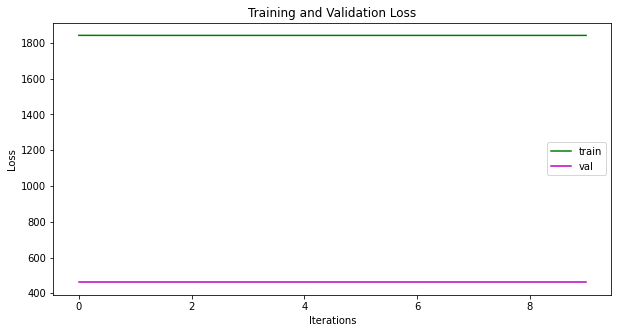

In [ ]:
#Plotting loss
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(train_graph_losses, color ="g")
plt.plot(val_graph_losses, color = "m")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(['train', 'val'])
plt.show()

No handles with labels found to put in legend.


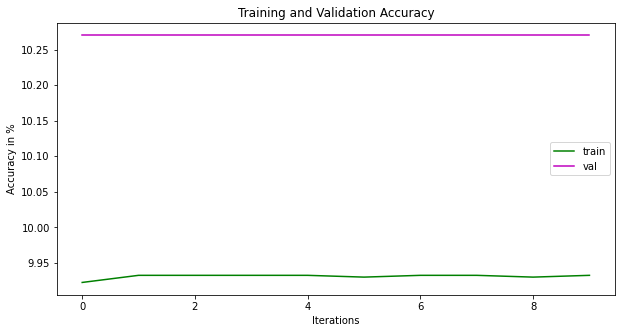

In [ ]:
#Plotting accuracy 
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(train_acc, color ="g")
plt.plot(val_acc, color = "m")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Accuracy in %")
plt.legend(['train', 'val'])
plt.show()

### Model 6

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

#2 Layers - fully convolutional 2 layers -> one dropout and one maxpooling operations
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        #self.fc1 = nn.Linear(6, 10)
        self.conv2 = nn.Conv2d(6, 10, 5)
        self.drop = nn.Dropout(p=0.5, inplace=False)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #x = F.relu(self.fc1(x))
        return x


model2 = Net2()

### Best Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
#Modified Base Model - 3 layer model with additional hyperparameters and dropoout/batchnorm
#One fully connected layer similar to Model 1 above 
class Net4(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=(5, 5))
        self.pool = nn.MaxPool2d(2, 2)
        self.batch1 = nn.BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True)
        self.drop = nn.Dropout(p=0.5, inplace=False)

        self.conv2 = nn.Conv2d(6, 16, kernel_size=(5, 5))
        self.pool = nn.MaxPool2d(2, 2)
        self.batch2 = nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
        self.drop = nn.Dropout(p=0.5, inplace=False)

        self.fc1 = nn.Linear(16 * 5 * 5, 10)
        self.drop = nn.Dropout(p=0.5, inplace=False)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.batch1(x)
        x = self.drop(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.batch2(x)
        x = self.drop(x)
        #x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions excluding batch
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        return x


model4 = Net4()

In [ ]:
#model summary --> helps with understanding layer composition 
from torchvision import models
from torchsummary import summary
summary(model4,(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
       BatchNorm2d-3            [-1, 6, 14, 14]              12
           Dropout-4            [-1, 6, 14, 14]               0
            Conv2d-5           [-1, 16, 10, 10]           2,416
         MaxPool2d-6             [-1, 16, 5, 5]               0
       BatchNorm2d-7             [-1, 16, 5, 5]              32
           Dropout-8             [-1, 16, 5, 5]               0
            Linear-9                   [-1, 10]           4,010
          Dropout-10                   [-1, 10]               0
Total params: 6,926
Trainable params: 6,926
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.08
Params size (MB): 0.03
Estimated Total

In [ ]:
#using torchviz library - print out the structure and exact dimensional 
#operations with network architecture
from torchviz import make_dot
x = torch.randn(6, 3, 32, 32)
y = model1(x)
make_dot(y.mean(), params=dict(model4.named_parameters()))

In [ ]:
#Repeated code snippet - See Model 1 Testing for more comments
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ExponentialLR, ReduceLROnPlateau
criterion = nn.CrossEntropyLoss()
#optimizer4 = optim.SGD(model4.parameters(), lr=0.001, momentum=0.9)
optimizer4 = optim.Adam(model4.parameters(),lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-6, amsgrad=False)
#optimizer4 = optim.RMSprop(model4.parameters(), lr=0.001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
#standard Expoential learning rate scheduler 
scheduler = ExponentialLR(optimizer4, gamma=0.9)

In [ ]:
#Repeated code snippet - See Model 1 Testing for more comments
losses = []
train_graph_losses = []
epoch__acc = []
train_acc = []
for epoch in range(5):  

    running_loss = 0.0
    correct = 0.0
    total = 0  
    for i, data in enumerate(trainloader):
        inputs, labels = data

        optimizer4.zero_grad()

        outputs = model4(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer4.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)   
        total += labels.size(0) 
        correct += (predicted == labels).sum().item()
        mean_train_accuracy = (100 * correct / total)  
        if i % 2000 == 1999:    # 2000 minibatches printed 
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            print('Train Accuracy: %d %%' % (mean_train_accuracy)) 
            running_loss = running_loss / 2000
            train_graph_losses.append(running_loss)
            train_acc.append(mean_train_accuracy)
            running_loss = 0.0
            print(epoch)
    
                     

    scheduler.step()

    epoch_loss = running_loss / len(train_data)
    losses.append(epoch_loss)
    print(epoch_loss)
    print('Training Accuracy: %d %%' % (mean_train_accuracy)) 
    

print('Finished Training')

[1,  2000] loss: 2.342
Train Accuracy: 12 %
0
[1,  4000] loss: 2.287
Train Accuracy: 11 %
0
[1,  6000] loss: 2.295
Train Accuracy: 11 %
0
[1,  8000] loss: 2.294
Train Accuracy: 11 %
0
[1, 10000] loss: 2.287
Train Accuracy: 10 %
0
[1, 12000] loss: 2.282
Train Accuracy: 10 %
0
0.11386751823425292
Training Accuracy: 10 %
[2,  2000] loss: 2.278
Train Accuracy: 10 %
1
[2,  4000] loss: 2.268
Train Accuracy: 11 %
1
[2,  6000] loss: 2.272
Train Accuracy: 11 %
1
[2,  8000] loss: 2.271
Train Accuracy: 11 %
1
[2, 10000] loss: 2.265
Train Accuracy: 11 %
1
[2, 12000] loss: 2.262
Train Accuracy: 11 %
1
0.11388571093082428
Training Accuracy: 11 %
[3,  2000] loss: 2.265
Train Accuracy: 11 %
2
[3,  4000] loss: 2.257
Train Accuracy: 11 %
2
[3,  6000] loss: 2.258
Train Accuracy: 11 %
2
[3,  8000] loss: 2.252
Train Accuracy: 11 %
2
[3, 10000] loss: 2.247
Train Accuracy: 11 %
2
[3, 12000] loss: 2.234
Train Accuracy: 12 %
2
0.11189022799730301
Training Accuracy: 12 %
[4,  2000] loss: 2.232
Train Accuracy: 1

#### Model 4 Validation

In [ ]:
#Repeated code snippet - See Model 1 Testing for more comments
val_acc = []
val_graph_losses = []     
for epoch in range(5):  # loop over the dataset multiple times
  correct = 0                                               
  total = 0                                                 
  running_loss = 0.0   
  model4.eval()                                              
  with torch.no_grad():                                     
    for i, data in enumerate(valloader):
      inputs, labels = data                             

      outputs = model4(inputs)                           
      loss = criterion(outputs, labels)                 
      _, predicted = torch.max(outputs.data, 1)         
      total += labels.size(0)                           
      correct += (predicted == labels).sum().item()     
      running_loss += loss.item()         
      mean_val_accuracy = (100 * correct / total)               
      mean_val_loss = ( running_loss )    

      if i % 2000 == 1999:    # print every 2000 mini-batches
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
              print('Validation Accuracy: %d %%' % (mean_val_accuracy))
              running_loss = running_loss / 2000
              val_graph_losses.append(running_loss) 
              val_acc.append(mean_val_accuracy)
              running_loss = 0.0
                                               
  print('Validation Accuracy: %d %%' % (mean_val_accuracy)) 
  print('Validation Loss:'  ,mean_val_loss )     

[1,  2000] loss: 2.106
Validation Accuracy: 26 %
[1,  4000] loss: 2.107
Validation Accuracy: 26 %
[1,  6000] loss: 2.104
Validation Accuracy: 26 %
[1,  8000] loss: 2.105
Validation Accuracy: 26 %
[1, 10000] loss: 2.103
Validation Accuracy: 26 %
[1, 12000] loss: 2.108
Validation Accuracy: 26 %
Validation Accuracy: 26 %
Validation Loss: 1053.920929312706
[2,  2000] loss: 2.102
Validation Accuracy: 26 %
[2,  4000] loss: 2.105
Validation Accuracy: 26 %
[2,  6000] loss: 2.103
Validation Accuracy: 26 %
[2,  8000] loss: 2.109
Validation Accuracy: 26 %
[2, 10000] loss: 2.105
Validation Accuracy: 26 %
[2, 12000] loss: 2.111
Validation Accuracy: 26 %
Validation Accuracy: 26 %
Validation Loss: 1049.3585891723633
[3,  2000] loss: 2.101
Validation Accuracy: 27 %
[3,  4000] loss: 2.099
Validation Accuracy: 27 %
[3,  6000] loss: 2.103
Validation Accuracy: 26 %
[3,  8000] loss: 2.097
Validation Accuracy: 26 %
[3, 10000] loss: 2.105
Validation Accuracy: 26 %
[3, 12000] loss: 2.117
Validation Accuracy: 

No handles with labels found to put in legend.


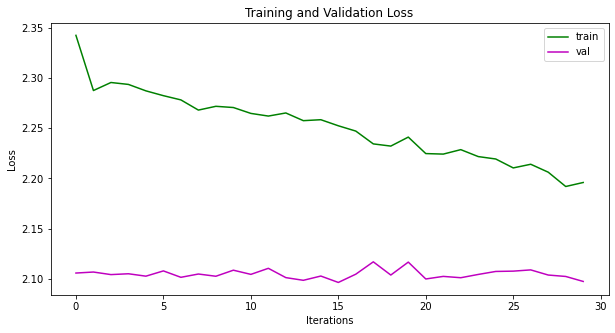

In [ ]:
#Plotting loss 
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(train_graph_losses, color ="g")
plt.plot(val_graph_losses, color = "m")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(['train', 'val'])
plt.show()

No handles with labels found to put in legend.


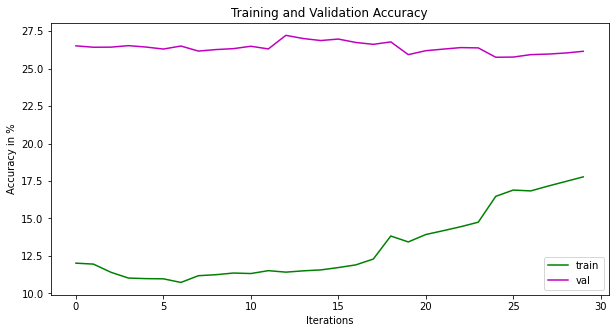

In [ ]:
#Plotting accuracy
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(train_acc, color ="g")
plt.plot(val_acc, color = "m")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Accuracy in %")
plt.legend(['train', 'val'])
plt.show()

In [ ]:
#4 Layers - fully linear layer - just utilises dropout - most accurate out of 3 4-layer models
#can be ignored early experiment in this investigation
class Net32(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32 * 3, 1024)
        self.drop = nn.Dropout(p=0.5, inplace=False)
        self.fc2 = nn.Linear(1024, 512)
        self.drop = nn.Dropout(p=0.5, inplace=False)
        self.fc3 = nn.Linear(512, 128)
        self.drop = nn.Dropout(p=0.5, inplace=False)
        self.fc4 = nn.Linear(128, 10)
        self.drop = nn.Dropout(p=0.5, inplace=False)
        

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = F.relu(self.fc3(x))
        x = self.drop(x)
        x = F.relu(self.fc4(x))
        x = self.drop(x)
        return x


model32 = Net32()

### Base Model

In [ ]:
#intial model with best accuracy - simple structure with additional operations 
#after convolutional layer
class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.batch1 = nn.BatchNorm2d(6, eps=1e-05, momentum=0.4, affine=True)
        self.drop = nn.Dropout(p=0.5, inplace=False)
        #self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.batch2 = nn.BatchNorm2d(16, eps=1e-05, momentum=0.4, affine=True)
        self.drop = nn.Dropout(p=0.5, inplace=False)
        #self.pool = nn.AvgPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 10)
        #self.drop = nn.Dropout(p=0.5, inplace=False)
        

    def forward(self, x):
        #x = F.relu(self.conv1(x))
        #x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv1(x)))
        x = self.batch1(x)
        x = self.drop(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.batch2(x)
        x = self.drop(x)
        #x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions excluding batch
        x = F.relu(self.fc1(x))
        return x


model1 = Net1()

## Testing on Testset

In [ ]:
#loading test images --> for test predictions
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

### Model 1 (3 hidden layers)

In [ ]:
#specifying test images as output
outputs = model21(images)

In [ ]:
#predictions on test images
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  frog  frog  frog  frog 


In [ ]:
#as this is the testing step, no gradients or forward/backward operations need
#to be considered
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model21(images)
        # highest energy class chosen as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 15 %


In [ ]:
#Predictions for each class are specified here on the testset
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

#no gradient operations required
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model21(images)
        _, predictions = torch.max(outputs, 1)
        # collecting correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# printing accuracy for each specified class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: airplane is 86.1 %
Accuracy for class: automobile is 0.0 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 0.0 %
Accuracy for class: dog   is 0.2 %
Accuracy for class: frog  is 72.2 %
Accuracy for class: horse is 0.0 %
Accuracy for class: ship  is 0.0 %
Accuracy for class: truck is 0.0 %


### Model 2 (2 layers)

In [ ]:
#Repeated code snippet - See Model 1 Testing for more comments
outputs = model32(images)

In [32]:
#Repeated code snippet - See Model 1 Testing for more comments
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  automobile bird  cat   dog  


In [ ]:
#Repeated code snippet - See Model 1 Testing for more comments
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 7 %


In [ ]:
#Repeated code snippet - See Model 1 Testing for more comments
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model2(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: airplane is 19.9 %
Accuracy for class: automobile is 8.7 %
Accuracy for class: bird  is 9.1 %
Accuracy for class: cat   is 6.1 %
Accuracy for class: deer  is 13.2 %
Accuracy for class: dog   is 2.9 %
Accuracy for class: frog  is 4.8 %
Accuracy for class: horse is 1.4 %
Accuracy for class: ship  is 2.4 %
Accuracy for class: truck is 3.9 %


### Model 3(4 layers)

In [ ]:
#Repeated code snippet - See Model 1 Testing for more comments
outputs = model33(images)

In [ ]:
#Repeated code snippet - See Model 1 Testing for more comments
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  deer  deer  deer  deer 


In [ ]:
#Repeated code snippet - See Model 1 Testing for more comments
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model33(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 9 %


In [ ]:
#Repeated code snippet - See Model 1 Testing for more comments
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}


with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model33(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: airplane is 4.1 %
Accuracy for class: automobile is 0.0 %
Accuracy for class: bird  is 2.7 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 87.0 %
Accuracy for class: dog   is 0.0 %
Accuracy for class: frog  is 0.0 %
Accuracy for class: horse is 0.4 %
Accuracy for class: ship  is 2.3 %
Accuracy for class: truck is 0.0 %


#### Model 4 (Best model)

In [ ]:
#Repeated code snippet - See Model 1 Testing for more comments
outputs = model4(images)

In [ ]:
#Repeated code snippet - See Model 1 Testing for more comments
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   automobile automobile ship 


In [ ]:
#Repeated code snippet - See Model 1 Testing for more comments
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model4(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 25 %


In [ ]:
#Repeated code snippet - See Model 1 Testing for more comments
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model4(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: airplane is 59.4 %
Accuracy for class: automobile is 40.8 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: cat   is 26.4 %
Accuracy for class: deer  is 0.0 %
Accuracy for class: dog   is 44.5 %
Accuracy for class: frog  is 0.0 %
Accuracy for class: horse is 0.0 %
Accuracy for class: ship  is 23.8 %
Accuracy for class: truck is 55.6 %


## Experiments

In [ ]:
x = F.softmax(self.fc1(x), dim=1)

In [ ]:
 self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=1, padding=0)
        #self.pool = nn.MaxPool2d(2, 2)
        self.batch3 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.4, affine=True)
        self.drop3 = nn.Dropout(p=0.5, inplace=False)

        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=0)
        #self.pool = nn.MaxPool2d(2, 2)
        self.batch4 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.4, affine=True)
        self.drop4 = nn.Dropout(p=0.5, inplace=False)

        self.fc1 = nn.Linear(,10) # I
        self.drop5 = nn.Dropout(p=0.5, inplace=False)

In [ ]:
from torch.utils.data import dataset
#lists to store information about loss and accuracy
losses = []
train_graph_losses = []
epoch__acc = []
train_acc = []
for epoch in range(2):  # looping through dataset - epoch specification
    #storing information - needed for plotting later 
    running_loss = 0.0
    correct = 0.0
    total = 0  
    for i, data in enumerate(trainloader):
        #data is stored as list of inputs with labels
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer1.zero_grad()

        # forward, backward and optimization step 
        outputs = model22(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer1.step()


        # print necessary information about loss, accuracy etc.
        _, predicted = torch.max(outputs.data, 1)   
        #total += labels.size(0)
        #correct += (predicted == labels).sum().item()

        #correct += (predicted == labels).sum().item()
        running_loss += loss.item()
        mean_train_accuracy += accuracy(outputs, labels)
        #mean_train_accuracy = mean_train_accuracy / len(train_data)
        #mean_train_accuracy = (100 * correct / total) 
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            print('Train Accuracy: %d %%' % (mean_train_accuracy)) 
            #storing loss and accuracy information for plotting
            #dividing loss
            running_loss = running_loss / 2000
            running_loss = 0.0

    train_graph_losses.append(running_loss)
    train_acc.append(mean_train_accuracy)
        
    #print("Accuracy = {}".format(mean_train_accuracy))
              
    #scheduler 
    scheduler.step()
    #More print statements on loss after epoch
    epoch_loss = running_loss / len(train_data)
    losses.append(epoch_loss)
    print(epoch_loss)
    print('Training Accuracy: %d %%' % (mean_train_accuracy)) 
    
print('Training Accuracy: %d %%' % (mean_train_accuracy)) 
print('Training Loss:' ,running_loss )       

print('Finished Training')

Old training and validation loop

In [ ]:
#Repeated code snippet - See Model 1 Testing for more comments
losses = []
train_graph_losses = []
epoch__acc = []
train_acc = []
for epoch in range(2): 

    running_loss = 0.0
    correct = 0.0
    total = 0  
    for i, data in enumerate(trainloader):
        inputs, labels = data

        optimizer3.zero_grad()

        outputs = model33(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer3.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)   
        total += labels.size(0) 
        correct += (predicted == labels).sum().item()
        mean_train_accuracy = (100 * correct / total)  
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            print('Train Accuracy: %d %%' % (mean_train_accuracy)) 
            #Storing accuracy and loss information
            running_loss = running_loss / 2000
            train_graph_losses.append(running_loss)
            train_acc.append(mean_train_accuracy)
            running_loss = 0.0
    
                     

    scheduler.step()

    epoch_loss = running_loss / len(train_data)
    losses.append(epoch_loss)
    print(epoch_loss)
    print('Training Accuracy: %d %%' % (mean_train_accuracy)) 
    

print('Finished Training')

In [ ]:
total_epochs = notebook.tqdm(range(num_epochs))
train_graph_losses = []
train_acc = []
for epoch in range(num_epochs):  
    running_loss = 0.0
    correct = 0.0
    total = 0  
    for i, (inputs,labels) in enumerate(trainloader):
        inputs,labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        #inputs, labels = inputs.to(device), labels.to(device)

        optimizer1.zero_grad()

        outputs = model22(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer1.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)   
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        #if i % 2000 == 1999:   
            #print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            #print('Train Accuracy: %d %%' % (mean_train_accuracy)) 
            #storing loss and accuracy information for plotting
            #running_loss = running_loss / 2000
        train_graph_losses.append(running_loss)
        train_acc.append(mean_train_accuracy)
            #running_loss = 0.0

        #if (i + 1) % 10 == 0:
          #total_epochs.set_description(
            #'Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                #epoch + 1, num_epochs, i + 1, len(trainloader), loss.item()))
     
    #running_loss=running_loss/len(trainloader)
    #mean_train_accuracy = (100 * correct / total) 
  
    #train_graph_losses.append(running_loss)
    #train_acc.append(mean_train_accuracy) 

    scheduler.step()  
    
print('Validation Accuracy: %d %%' % (mean_train_accuracy)) 
print('Validation Loss:'  ,mean_train_loss )      
print('Finished Training')

In [ ]:
#Repeated code snippet - See Model 1 Testing for more comments
val_acc = []
val_graph_losses = []     
for epoch in range(5):  # loop over the dataset multiple times
  correct = 0                                               
  total = 0                                                 
  running_loss = 0.0   
  model4.eval()                                              
  with torch.no_grad():                                     
    for i, data in enumerate(valloader):
      inputs, labels = data                             

      outputs = model4(inputs)                           
      loss = criterion(outputs, labels)                 
      _, predicted = torch.max(outputs.data, 1)         
      total += labels.size(0)                           
      correct += (predicted == labels).sum().item()     
      running_loss += loss.item()         
      mean_val_accuracy = (100 * correct / total)               
      mean_val_loss = ( running_loss )    

      if i % 2000 == 1999:    # print every 2000 mini-batches
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
              print('Validation Accuracy: %d %%' % (mean_val_accuracy))
              running_loss = running_loss / 2000
              val_graph_losses.append(running_loss) 
              val_acc.append(mean_val_accuracy)
              running_loss = 0.0
                                               
  print('Validation Accuracy: %d %%' % (mean_val_accuracy)) 
  print('Validation Loss:'  ,mean_val_loss ) 

In [ ]:
from torch.utils.tensorboard import SummaryWriter

# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

#training loop
writer.add_scalar('Loss/train', running_loss, global_step)

#testing
writer.add_scalar('Loss/val', val_running_loss, global_step)

writer.close()
